In [1]:
#!pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 tensorflow-io matplotlib
!pip install tensorflow matplotlib
!pip install tensorflow-gpu
import tensorflow as tf

!pip install tensorflow_io
!pip install librosa


  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... done
  Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/private/var/folders/y0/s184dnrd5mq750rsrsmkrtwm0000gn/T/pip-install-t70v_y_r/tensorflow-gpu_d983cf718b4d4a7688b0235fd6f6a9ad/setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      


/Users/harsh/Projects/coocket_whistle_python/cooker_pybook/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import librosa
import numpy as np


In [3]:
# Example: Update with the actual path to your 'Split Training Data' folder
os.listdir('/Users/harsh/Projects/coocket_whistle_python/Data/Not Whistles')

BASE_PATH = '/Users/harsh/Projects/coocket_whistle_python/Data'

# Now, you can join this base path with your individual file names
CAPUCHIN_FILE = os.path.join(BASE_PATH, 'Split Training Data WAV/output/Only_whistle_1.wav')  # Example file name
NOT_CAPUCHIN_FILE = os.path.join(BASE_PATH, 'Not Whistles/afternoon-birds-song-in-forest-0.wav')  # Example file name

In [4]:
def load_wav_16k_mono(filename):
    if tf.is_tensor(filename):
        filename = filename.numpy().decode('utf-8')
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    #wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
    wav, sr = librosa.load(filename, sr=None)
    wav_resampled = librosa.resample(wav, orig_sr=sr, target_sr=16000)

    return wav_resampled

In [5]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

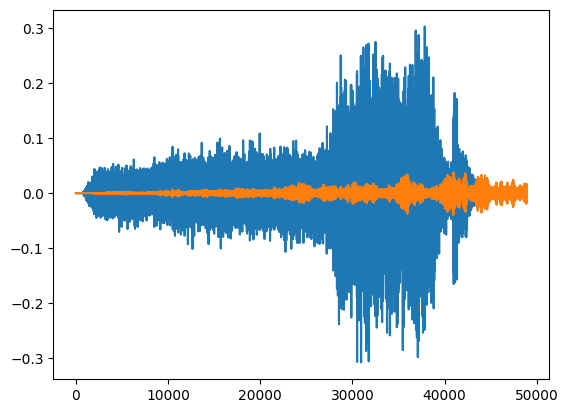

In [6]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [7]:
POS = os.path.join(BASE_PATH, 'Split Training Data WAV/output')
NEG = os.path.join(BASE_PATH, 'Not Whistles')

In [8]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [9]:
def get_dataset_size(dataset):
    count = 0
    for _ in dataset:
        count += 1
    return count

pos_size = get_dataset_size(pos)
neg_size = get_dataset_size(neg)

positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(pos_size))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(neg_size))))
data = positives.concatenate(negatives)


In [10]:
neg_size

36

In [11]:
lengths = []
for file in os.listdir(os.path.join(BASE_PATH, 'Split Training Data WAV/output')):
    if file.endswith('.wav'):
        #wav, sr = librosa.load(os.path.join(BASE_PATH, 'Split Training Data WAV', file), sr=16000, mono=True)
        #lengths.append(len(wav))
        tensor_wave = load_wav_16k_mono(os.path.join(BASE_PATH, 'Split Training Data WAV/output', file))
        lengths.append(len(tensor_wave))

In [12]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=66518>

In [13]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=66518>

In [14]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=183296>

In [15]:
def preprocess(file_path, label):
    # [wav, label] = tf.py_function(load_wav_16k_mono, [file_path], [tf.float32, label.dtype])
    # wav.set_shape([48000])
    # zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    # wav = tf.concat([zero_padding, wav], 0)
    # spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    # spectrogram = tf.abs(spectrogram)
    # spectrogram = tf.expand_dims(spectrogram, -1)
    # return spectrogram, label
    if tf.is_tensor(file_path):
        file_path_str = file_path.numpy().decode('utf-8')
    else:
        file_path_str = file_path  
    wav = load_wav_16k_mono(file_path_str)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [16]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [17]:
spectrogram, label = preprocess(filepath, label)

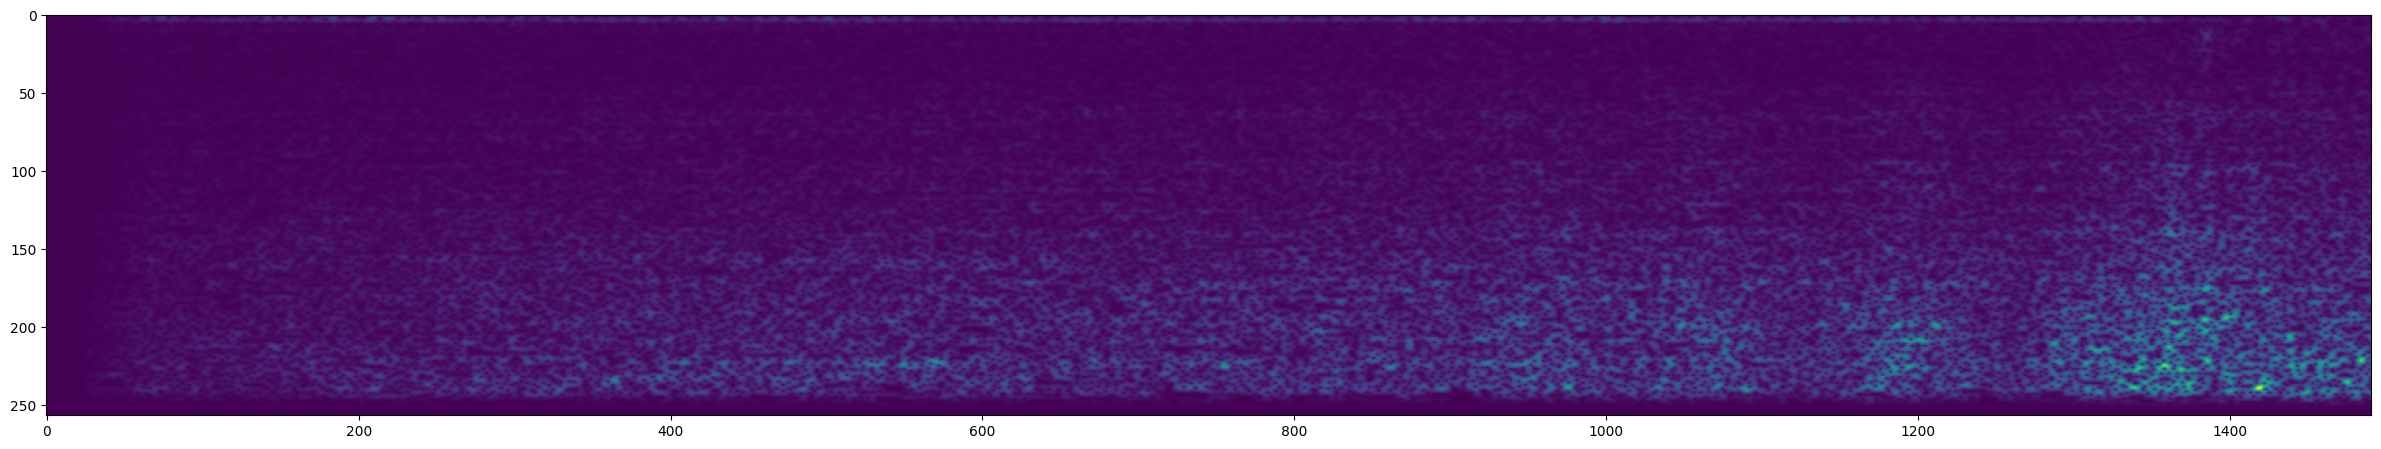

In [18]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [19]:
def tf_preprocess(file_path, label):
    [spectrogram, label] = tf.py_function(preprocess, [file_path, label], [tf.float32, label.dtype])
    return spectrogram, label

data = data.map(tf_preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(19)
data = data.prefetch(8)

In [20]:
train = data.take(5)
test = data.skip(5).take(1)

In [21]:
for samples, labels in train.take(3):
    display("aaa")


'aaa'

'aaa'

'aaa'

In [22]:
samples, labels = train.as_numpy_iterator().next()

In [23]:
samples.shape

(19, 1491, 257, 1)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [25]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770482865 (2.87 GB)
Trainable params: 770482865 (2.87 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
5/5 [==============================] - 35s 7s/step - loss: 3.1887 - recall: 0.9275 - precision: 0.7356 - val_loss: 4.0130 - val_recall: 1.0000 - val_precision: 0.7368
Epoch 2/4
5/5 [==============================] - 31s 6s/step - loss: 4.1735 - recall: 1.0000 - precision: 0.7263 - val_loss: 2.4078 - val_recall: 1.0000 - val_precision: 0.8421
Epoch 3/4
5/5 [==============================] - 30s 6s/step - loss: 4.1735 - recall: 1.0000 - precision: 0.7263 - val_loss: 4.0130 - val_recall: 1.0000 - val_precision: 0.7368
Epoch 4/4
5/5 [==============================] - 29s 6s/step - loss: 4.3340 - recall: 1.0000 - precision: 0.7158 - val_loss: 5.6181 - val_recall: 1.0000 - val_precision: 0.6316


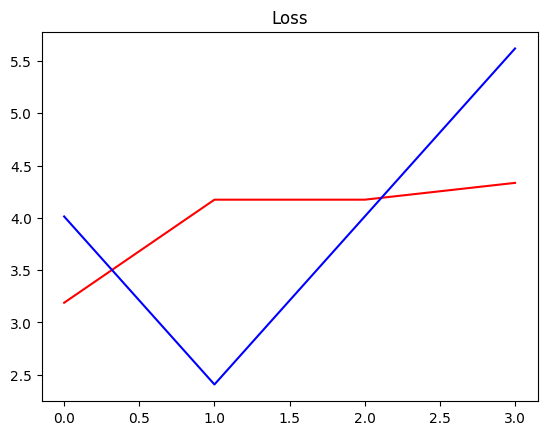

In [29]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [30]:
hist.history

{'loss': [3.188661575317383,
  4.173475742340088,
  4.173475742340088,
  4.333993911743164],
 'recall': [0.9275362491607666, 1.0, 1.0, 1.0],
 'precision': [0.7356321811676025,
  0.7263157963752747,
  0.7263157963752747,
  0.7157894968986511],
 'val_loss': [4.012957572937012,
  2.4077744483947754,
  4.012957572937012,
  5.61814022064209],
 'val_recall': [1.0, 1.0, 1.0, 1.0],
 'val_precision': [0.7368420958518982,
  0.8421052694320679,
  0.7368420958518982,
  0.6315789222717285]}

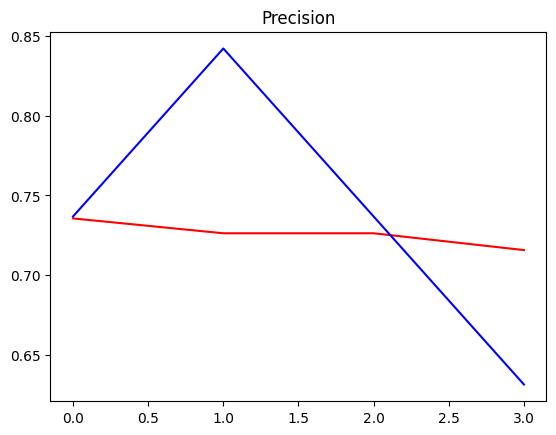

In [32]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

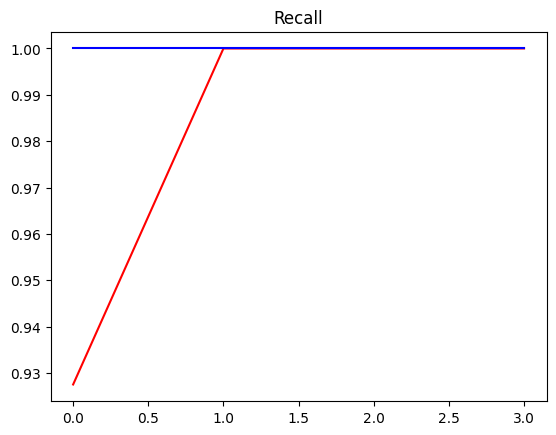

In [34]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [36]:
os.listdir('/Users/harsh/Projects/coocket_whistle_python/Data/Not Whistles')

BASE_PATH = '/Users/harsh/Projects/coocket_whistle_python/Data'

# Now, you can join this base path with your individual file names
#test_file_path = os.path.join(BASE_PATH, 'Split Training Data WAV/output/Only_whistle_set_3 (46).wav') 
test_file_path = os.path.join(BASE_PATH, 'Not Whistles/afternoon-birds-song-in-forest-0.wav') 

# Step 1: Load the test audio file
test_audio = load_wav_16k_mono(test_file_path)

# Step 2: Preprocess the test audio
test_spectrogram, _ = preprocess(test_file_path, 0)  # Assuming label doesn't matter for testing

# Ensure the input is in the correct shape for the model
test_spectrogram = tf.expand_dims(test_spectrogram, 0)

# Step 3: Predict
prediction = model.predict(test_spectrogram)
print("Prediction:", prediction)
confidence = prediction[0][0]
print("Conf:", confidence)



1/1 [==============================] - 0s 190ms/step
Prediction: [[1.]]
Conf: 1.0


In [ ]:
#model.save( os.path.join(BASE_PATH, 'testmodel'))

INFO:tensorflow:Assets written to: /Users/harsh/Projects/coocket_whistle_python/Data/testmodel/assets


INFO:tensorflow:Assets written to: /Users/harsh/Projects/coocket_whistle_python/Data/testmodel/assets
